# Import Libraries

In [1]:
# data handling
import pandas as pd
import numpy as np
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# load numpy array from csv file
from numpy import loadtxt

#for splitting our data
from sklearn.model_selection import train_test_split

#plotting performance
import matplotlib.pyplot as plt

In [ ]:
!pip install --upgrade tensorflow_hub

In [ ]:
#used for transfer learning
import tensorflow_hub as hub

In [ ]:
!pip install tensorflow_decision_forests

In [ ]:
import tensorflow_decision_forests as tfdf #Windows, this library is still not available

In [2]:
#access google drive
#from google.colab import drive, files
#get data from google drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#check that we are using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Utility Functions
Custom functions to help with handling the data

## Text Encoder

In [4]:
def encode_text(text, encode_type, seq_len=3):
  """
  Input txt and outputs tokenised text.
  encode_type: bow = encode documents into vector where the coefficient for 
  each token is based on counting words
  """
  if(encode_type == 'bow'):
    encoder = Tokenizer()# create the tokenizer
    encoder.fit_on_texts(text)
    bow = encoder.texts_to_matrix(text, mode='count')
    # summarize what was learned
    print("Encoder Summary:\n")
    print(encoder.word_counts)
    print(encoder.document_count)
    print(encoder.word_index)
    print(encoder.word_docs)
    print(type(bow))
    print(bow.shape) #8.26gb / 23677 = 0.00035 GB/column if saved to file and 200205 * 0.00035 = 70GB if saved to file!
    return bow
  elif(encode_type == 'sequence'):
    encoder = Tokenizer()# create the tokenizer
    encoder.fit_on_texts(text)
    
    t2s = encoder.texts_to_sequences(text)
    pt2s = pad_sequences(t2s, padding='post', truncating='post', maxlen=seq_len)
    print(pt2s)
    print(type(pt2s))
    print(pt2s.shape)
    return pt2s

  elif(encode_type == 'one-hot'):
    labels = pd.get_dummies(text).values
    print(labels.shape)
    return labels

def train_val_test(X_features, y_target, tc=237, pt_embed=False):
    """
    Splits dataset into 10% for testting, 10% for validation and 
    the remaining 80% for training data. By first spliting data for 
    training and test data (90:10), then training with validation.

    returns X_train, X_test, X_val, max_words, seq_len
    """
    # Reduce word amount to speed up training
    truncate = tc #592 #1183 #2368 #6000 # 23677 
    mxw = 23681 #our vocab value we found during data cleaning
    sl = truncate

    X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_features, y_target, test_size=0.1, random_state=42)

    X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(X_train_set, y_train_set, test_size=0.1111, random_state=42)

    print("** Before Truncate **")
    print("Training data shape:", X_train_set.shape)
    print("Training labels shape:", y_train_set.shape)
    print("\n")
    print("Validation data shape:", X_val_set.shape)
    print("Validation labels shape:", y_val_set.shape)
    print("\n")
    print("Test data shape:", X_test_set.shape)
    print("Test labels shape:", y_test_set.shape)

    if(pt_embed):
      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl
    else:
      X_train_set = X_train_set[:, :truncate]
      X_test_set = X_test_set[:, :truncate]
      X_val_set = X_val_set[:, :truncate]

      print("\n")
      print("** After Truncate: " + str(truncate) + " **")
      print("Training data shape:", X_train_set.shape)
      print("Training labels shape:", y_train_set.shape)
      print("\n")
      print("Validation data shape:", X_val_set.shape)
      print("Validation labels shape:", y_val_set.shape)
      print("\n")
      print("Test data shape:", X_test_set.shape)
      print("Test labels shape:", y_test_set.shape)

      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl

## Target Encoding: SectionName

### Load prepared SectionName dataset

In [5]:
y = pd.read_csv('/content/drive/MyDrive/data/y_raw.csv') #sectionName only
y.head()

,sectionName
0,football
1,sport
2,world news
3,sport
4,art design


In [6]:
y = y.sectionName.values

### One-Hot-Encode SectionName

In [7]:
y = encode_text(y, encode_type='one-hot')

(14983, 82)


## Model Builder

In [8]:
def build_simple_rnn(id=1000, od=50, il=128, m_type='bow'):
    """
    returns a simple rnn model
    needs input_dim, output_dim and input_length passed.
    """
    if(m_type=='bow'):
      model = tf.keras.Sequential()
      #batch size (numer of observations), #number of columns (timesteps), just have 1 indicator but can increase with more
      model.add(layers.Embedding(input_dim=id, 
                                output_dim=od,
                                input_length=il))
      model.add(layers.GlobalAveragePooling1D())
      model.add(layers.Reshape((1, od)))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model
    elif(m_type=='word_vector'):
      model = tf.keras.Sequential()
      #batch size (numer of observations), #number of columns (timesteps), just have 1 indicator but can increase with more
      model.add(layers.Embedding(input_dim=id, 
                                output_dim=od,
                                input_length=il))
      model.add(layers.Conv1D(25,3,padding='valid',activation='relu',strides=1))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model
    elif(m_type=='pre_trained'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      model.add(layers.Reshape((1, od)))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      #regularisation layer which randomly turns off 
      #activations of some neurons in the model to prevent overfitting
      model.add(layers.Dropout(0.5))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_lstm(id=1000, od=50, il=128, m_type='single'):
    if(m_type=='single'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      #we need to reshape our data for LSTM. 
      # It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Reshape((128, 1))) # model.add(layers.Reshape((1, od)))
      model.add(layers.LSTM(8))
      model.add(layers.Dropout(0.5))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
      model.summary()
      return model
    elif(m_type=='multi'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      #we need to reshape our data for LSTM. 
      # It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Reshape((1, od))) #model.add(layers.Reshape((128, 1))) 
      model.add(layers.LSTM(8, return_sequences=True))
      model.add(layers.LSTM(8))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_cnn(m_type='mhks_cnn'):
    if(m_type=='mhks_cnn'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      model.add(layers.Reshape((128, 1)))  # Add a time step dimension
      model.add(layers.Conv1D(128, 5, activation='relu'))
      model.add(layers.Conv1D(65, 5, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(10, activation='relu'))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      model.summary()
      return model
    elif(m_type=='mhks_cnn_lstm'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      model.add(layers.Reshape((128, 1)))  # Add a time step dimension
      model.add(layers.LSTM(82, return_sequences=True))
      #model.add(layers.Reshape((64, 0))) #we need to reshape our data for LSTM. It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Conv1D(128, 5, activation='relu'))
      model.add(layers.Conv1D(64, 5, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(10, activation='relu'))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_random_forest():
      model = tfdf.keras.RandomForestModel(verbose=2)
      return model



# Simple RNN: On-the-fly Word Embeddings

## WebTitle Data

### WebTitle Bag-Of-Words
One hot encoding words and using GlobalAveragePooling1D to encode them.

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

#### Encode Bag-of-Words Representation

In [ ]:
X = encode_text(X, encode_type='bow')

Encoder Summary:

OrderedDict([('saido', 1), ('berahino', 1), ('right', 91), ('attitude', 3), ('hes', 25), ('fit', 16), ('says', 515), ('west', 108), ('broms', 1), ('pulis', 1), ('angelique', 1), ('kerber', 1), ('aims', 16), ('dislodge', 1), ('serena', 9), ('williams', 59), ('world', 295), ('no1', 3), ('spot', 20), ('family', 95), ('building', 13), ('refugee', 35), ('shadow', 15), ('isis', 19), ('exeter', 13), ('keep', 79), ('saracens', 19), ('sights', 5), ('bonus', 11), ('point', 34), ('win', 148), ('worcester', 5), ('exposed', 19), ('photographys', 1), ('fabulous', 5), ('fakes', 2), ('bank', 81), ('england', 279), ('governor', 12), ('caught', 14), ('bluffing', 1), ('interest', 25), ('rates', 25), ('senior', 15), ('tory', 73), ('urges', 41), ('eurosceptics', 1), ('show', 106), ('integrity', 8), ('vote', 82), ('leave', 70), ('eu', 142), ('holding', 7), ('back', 233), ('growth', 23), ('solar', 15), ('power', 92), ('herons', 1), ('review', 977), ('feral', 2), ('smash', 5), ('grab', 10), 

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 23677)
Training labels shape: (11985, 82)


Validation data shape: (1499, 23677)
Validation labels shape: (11985, 82)


Test data shape: (1499, 23677)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle BOW
Input will be passed to an basic RNN layer - sequences will be generated 

In [ ]:
RNN_model = keras.models.load_model("./models/part-1/rnn_model-wt-bow")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d_3   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 reshape_1 (Reshape)         (None, 1, 50)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 472       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 82)                738       
                                                      

#### Train Simple RNN Model using webTitle BOW

#### Evaluation of Simple RNN Model using webTitle BOW

In [ ]:
print("RNN - WebTitle - BOW")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle - BOW
47/47 - 0s - loss: 3.3130 - accuracy: 0.0894 - 186ms/epoch - 4ms/step
RNN Test Loss 3.313
RNN Test Accuracy 0.089


### webTitle Sequence

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

#### Encode Word Sequence Vector Representation

In [ ]:
X = encode_text(X, encode_type='sequence', seq_len=237) #592 #1183 #2368 #6000 # 23677

[[11115 11116   118 ...     0     0     0]
 [11119 11120  1430 ...     0     0     0]
 [  105  1775   534 ...     0     0     0]
 ...
 [ 3954   215   252 ...     0     0     0]
 [ 1536  4797    42 ...     0     0     0]
 [11006   911 10361 ...     0     0     0]]
<class 'numpy.ndarray'>
(14983, 237)


#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle T2S

In [ ]:
RNN_model = keras.models.load_model("./models/part-1/rnn_model-wt-t2s")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 237, 50)           1184050   
                                                                 
 conv1d (Conv1D)             (None, 235, 25)           3775      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 8)                 272       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 82)                738       
                                                                 
Total params: 1,188,835
Trainable params: 1,188,835
Non-trainable params: 0
_________________________________________________________________


#### Evaluation of Simple RNN Model using webTitle T2S

In [ ]:
print("RNN - WebTitle - T2S")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle - T2S
47/47 - 1s - loss: 3.3135 - accuracy: 0.0894 - 764ms/epoch - 16ms/step
RNN Test Loss 3.314
RNN Test Accuracy 0.089


## WebTitle & BodyContent (Additional Data)

### WebTitle & BodyContent Bag-Of-Words

#### Replace webTitle dataset with prepared webTitle & BodyContent dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt_bc.csv') #WebTitle only
X.head()

,webTitle_bodyContent
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis 9 june 201...
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes 1840 hippo...


In [ ]:
X = X.webTitle_bodyContent.values

In [ ]:
print(X.shape)

(14983,)

#### Encode Bag-of-Words Representation

In [ ]:
X = encode_text(X, encode_type='bow')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(X)

[[0. 5. 2. ... 0. 0. 0.]
 [0. 2. 2. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 6. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 6. 1. ... 1. 1. 1.]]


In [ ]:
print(X.shape)

(14983, 200205)


In [ ]:
X = X[:, :23677] #colab was crashing as too high

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 23677)
Training labels shape: (11985, 82)


Validation data shape: (1499, 23677)
Validation labels shape: (11985, 82)


Test data shape: (1499, 23677)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle & BodyContent Bag of words 
Input will be passed to an basic RNN layer - sequences will be generated 

In [ ]:
RNN_model = keras.models.load_model("./models/part-1/rnn_model-wt-bc-bow")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 50)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 472       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 82)                738       
                                                        

#### Evaluation of Simple RNN Model using webTitle & BodyContent Bag of words 

In [ ]:
print("RNN - WebTitle & BodyContent - BOW")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", loss_and_metrics[0])
print("RNN Test Accuracy", loss_and_metrics[1])

RNN - WebTitle & BodyContent - BOW
47/47 - 0s - loss: 3.2881 - accuracy: 0.0894 - 135ms/epoch - 3ms/step
RNN Test Loss 3.2880752086639404
RNN Test Accuracy 0.08939293026924133


### WebTitle & BodyContent Sequence

#### Reload prepared WebTitle & BodyContent dataset

In [9]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt_bc.csv') #WebTitle only
X.head()

,webTitle_bodyContent
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis 9 june 201...
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes 1840 hippo...


In [10]:
X = X.webTitle_bodyContent.values

#### Encode Word Sequence Vector Representation

In [11]:
X = encode_text(X, encode_type='sequence', seq_len=237) #592 #1183 #2368 #6000 # 23677

[[42542 37092    62 ...   518  3481   153]
 [26864 22351  3413 ...     6  1053  1377]
 [   79   576  2128 ...     4   151 24291]
 ...
 [11541   662  1212 ...   276 33900  3329]
 [ 3002 10330   206 ...     0     0     0]
 [12301   211 24372 ...  7433  2981    12]]
<class 'numpy.ndarray'>
(14983, 237)


In [12]:
print(X.shape)

(14983, 237)


In [13]:
np.any(X < 0)

False

#### Split WebTitle, BodyContent & sectionName into 80% training, 10% test & 10% validation datasets

In [14]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (1499, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (1499, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using WebTitle & BodyContent T2S

In [15]:
RNN_model = keras.models.load_model("./models/part-1/rnn_model_wt_bc_t2s")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 237, 50)           1184050   
                                                                 
 conv1d (Conv1D)             (None, 235, 25)           3775      
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 272       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 82)                738       
                                                                 
Total params: 1,188,835
Trainable params: 1,188,835
Non-trainable params: 0
_________________________________________________________________


#### Evaluation of Simple RNN Model using WebTitle & BodyContent T2S

In [19]:
print("RNN - WebTitle & BodyContent - T2S")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle & BodyContent - T2S
47/47 - 1s - loss: 3.6933 - accuracy: 0.0847 - 899ms/epoch - 19ms/step
RNN Test Loss 3.693
RNN Test Accuracy 0.085


# Simple RNN: Pretrained Word Embeddings

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle pretrained embeddings

In [ ]:
RNN_model = keras.models.load_model("./models/part-1/rnn_model-wt-pte")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_11 (KerasLayer)  (None, 128)              124642688 
                                                                 
 reshape_10 (Reshape)        (None, 1, 128)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 8)                 1096      
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 82)                738       
                                                                 
Total params: 124,644,522
Trainable params: 124,644,522
Non-trainable params: 0
_________________________________________________________________


#### Evaluation of Simple RNN Model using webTitle T2S

In [ ]:
print("RNN - WebTitle - PTE")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle - PTE
47/47 - 21s - loss: 2.4943 - accuracy: 0.4136 - 21s/epoch - 447ms/step
RNN Test Loss 2.494
RNN Test Accuracy 0.414


# Single LSTM

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build LSTM Model

In [ ]:
LSTM_model = keras.models.load_model("./models/part-1/lstm_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 82)                410       
                                                                 
Total params: 124,643,194
Trainable params: 124,643,194
Non-trainable params: 0
_________________________________________________________________


#### Evaluation of LSTM Model

In [ ]:
print("LSTM")
loss_and_metrics = LSTM_model.evaluate(X_test, y_test, verbose=2)
print("LSTM Test Loss", round(loss_and_metrics[0], 3))
print("LSTM Test Accuracy", round(loss_and_metrics[1], 3))

LSTM
47/47 - 1s - loss: 3.1792 - accuracy: 0.0967 - 548ms/epoch - 12ms/step
LSTM Test Loss 3.179
LSTM Test Accuracy 0.097


# Multi-Layer LSTM Model

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build Multi-Layer LSTM Model

In [ ]:
LSTM_model = keras.models.load_model("./models/part-1/multi-lstm_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 8)              4384      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 82)                738       
                                                                 
Total params: 124,648,354
Trainable params: 124,648,354
Non-trainable params: 0
_________________________________________________________________


#### Evaluation of Multi-Layer LSTM Model

In [ ]:
print("Multi LSTM")
loss_and_metrics = LSTM_model.evaluate(X_test, y_test, verbose=2)
print("Multi LSTM Test Loss", round(loss_and_metrics[0], 3))
print("Multi LSTM Test Accuracy", round(loss_and_metrics[1], 3))

Multi LSTM
47/47 - 0s - loss: 3.0418 - accuracy: 0.2248 - 465ms/epoch - 10ms/step
Multi LSTM Test Loss 3.042
Multi LSTM Test Accuracy 0.225


# CNN Model

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build CNN Model

In [ ]:
CNN_model = keras.models.load_model("./models/part-1/cnn_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 65)           41665     
                                                                 
 global_max_pooling1d (Globa  (None, 65)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                660       
                                                        

#### Evaluation of CNN Model

In [ ]:
print("CNN")
loss_and_metrics = CNN_model.evaluate(X_test, y_test, verbose=2)
print("CNN Test Loss", round(loss_and_metrics[0], 3))
print("CNN Test Accuracy", round(loss_and_metrics[1], 3))

CNN
47/47 - 1s - loss: 7.7222 - accuracy: 0.2288 - 526ms/epoch - 11ms/step
CNN Test Loss 7.722
CNN Test Accuracy 0.229


# CNN+LSTM Model

#### Load prepared webTitle dataset

In [9]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [10]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [11]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build CNN & LSTM Model

In [12]:
CNN_LSTM_model = keras.models.load_model("./models/part-1/cnn_lstm_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 128, 82)           27552     
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          52608     
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 64)           41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                        

#### Evaluation of CNN & LSTM Model

In [16]:
print("CNN & LSTM")
loss_and_metrics = CNN_LSTM_model.evaluate(X_test, y_test, verbose=2)
print("CNN & LSTM Test Loss", round(loss_and_metrics[0], 3))
print("CNN & LSTM Test Accuracy", round(loss_and_metrics[1], 3))

CNN & LSTM
47/47 - 0s - loss: 7.7039 - accuracy: 0.2288 - 460ms/epoch - 10ms/step
CNN & LSTM Test Loss 7.704
CNN & LSTM Test Accuracy 0.229


# Random Forest Model

#### Load prepared webTitle dataset and recode sectionName

In [10]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [11]:
X = X.webTitle.values

#### Encode Word Sequence Vector Representation

In [12]:
X = encode_text(X, encode_type='sequence', seq_len=237) #592 #1183 #2368 #6000 # 23677

[[11115 11116   118 ...     0     0     0]
 [11119 11120  1430 ...     0     0     0]
 [  105  1775   534 ...     0     0     0]
 ...
 [ 3954   215   252 ...     0     0     0]
 [ 1536  4797    42 ...     0     0     0]
 [11006   911 10361 ...     0     0     0]]
<class 'numpy.ndarray'>
(14983, 237)


In [23]:
y = np.argmax(y, axis=1)
print(y)
print(y.shape)

[22 67 81 ... 72 81 81]
(14983,)


#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [24]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 237)
Training labels shape: (11985,)


Validation data shape: (1499, 237)
Validation labels shape: (1499,)


Test data shape: (1499, 237)
Test labels shape: (1499,)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985,)


Validation data shape: (1499, 237)
Validation labels shape: (1499,)


Test data shape: (1499, 237)
Test labels shape: (1499,)


#### Convert into tensor datasets and create batches

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [26]:
train_dataset = train_dataset.batch(100)
val_dataset = val_dataset.batch(100)
test_dataset = test_dataset.batch(100)

#### Build Random Forest Model

In [27]:
rf_model = keras.models.load_model("./models/part-1/rf_model")

Use 2 thread(s) for training
Use /tmp/tmprszm1y17 as temporary training directory


In [29]:
rf_model.compile(metrics=["accuracy"])

In [30]:
rf_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (237):
	data:0.0
	data:0.1
	data:0.10
	data:0.100
	data:0.101
	data:0.102
	data:0.103
	data:0.104
	data:0.105
	data:0.106
	data:0.107
	data:0.108
	data:0.109
	data:0.11
	data:0.110
	data:0.111
	data:0.112
	data:0.113
	data:0.114
	data:0.115
	data:0.116
	data:0.117
	data:0.118
	data:0.119
	data:0.12
	data:0.120
	data:0.121
	data:0.122
	data:0.123
	data:0.124
	data:0.125
	data:0.126
	data:0.127
	data:0.128
	data:0.129
	data:0.13
	data:0.130
	data:0.131
	data:0.132
	data:0.133
	data:0.134
	data:0.135
	data:0.136
	data:0.137
	data:0.138
	data:0.139
	data:0.14
	data:0.140
	data:0.141
	data:0.142
	data:0.143
	data:0.144
	data:0.145
	

In [31]:
rf_model.make_inspector().variable_importances()

{'SUM_SCORE': [("data:0.0" (1; #1), 1276792.850563841),
  ("data:0.1" (1; #2), 1209725.9603570017),
  ("data:0.2" (1; #113), 940164.443217485),
  ("data:0.4" (1; #172), 819369.6174872778),
  ("data:0.3" (1; #161), 778447.0343095136),
  ("data:0.5" (1; #183), 695820.9083138658),
  ("data:0.6" (1; #194), 639198.5806914368),
  ("data:0.7" (1; #205), 548379.5529892647),
  ("data:0.8" (1; #216), 328891.26334190555),
  ("data:0.9" (1; #227), 212515.09116994217),
  ("data:0.10" (1; #3), 66071.74969676882),
  ("data:0.11" (1; #14), 6066.39696457237),
  ("data:0.12" (1; #25), 333.56837948411703),
  ("data:0.13" (1; #36), 44.35746847093105)],
 'NUM_NODES': [("data:0.0" (1; #1), 61094.0),
  ("data:0.1" (1; #2), 58438.0),
  ("data:0.2" (1; #113), 48881.0),
  ("data:0.3" (1; #161), 48019.0),
  ("data:0.4" (1; #172), 46337.0),
  ("data:0.5" (1; #183), 41903.0),
  ("data:0.6" (1; #194), 33593.0),
  ("data:0.7" (1; #205), 24926.0),
  ("data:0.8" (1; #216), 17157.0),
  ("data:0.9" (1; #227), 9281.0),
 

#### Evaluation of Random Forest Model

In [32]:
evaluation = rf_model.evaluate(test_dataset, return_dict=True)
print()

15/15 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.2168



In [33]:
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

loss: 0.0000
accuracy: 0.2168


In [34]:
tfdf.model_plotter.plot_model_in_colab(rf_model, tree_idx=0, max_depth=3)

In [35]:
rf_model.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=4385, accuracy=0.12702394526795896, loss=31.465244755152288, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=11912, accuracy=0.13398253861652115, loss=25.42511675971303, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=11984, accuracy=0.15787716955941256, loss=20.981477284607525, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=11985, accuracy=0.16821026282853566, loss=18.267726701966453, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=11985, accuracy=0.1773884021693784, loss=16.289092804051073, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=11985, accuracy=0.18272841051314143, loss=14.6936307414

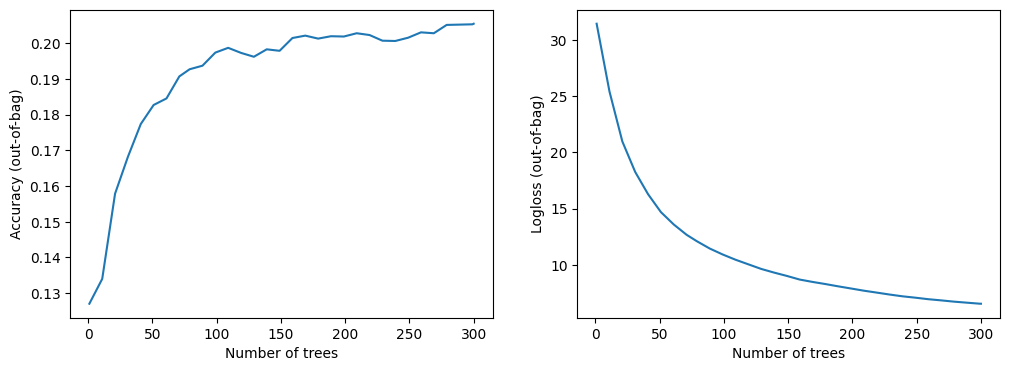

In [36]:
logs = rf_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# PART 2 Transfer Learning

## Import BBC Dataset

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/data/bbc-text.csv')
df = pd.read_csv('./data/bbc-text.csv')

In [ ]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


## Encode X and y

In [ ]:
X = df.text.values

In [ ]:
y = df.category.values

In [ ]:
y = encode_text(y, encode_type='one-hot')

(2225, 5)


#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (1779,)
Training labels shape: (1779, 5)


Validation data shape: (223,)
Validation labels shape: (223, 5)


Test data shape: (223,)
Test labels shape: (223, 5)


## Simple RNN: Pretrained Word Embeddings

In [ ]:

BBC_RNN_model = keras.models.load_model("./models/part-2/bbc_rnn_model-wt-pte")

In [ ]:
print("BBC: RNN - WebTitle - PTE")
loss_and_metrics = BBC_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC: RNN Test Loss", round(loss_and_metrics[0], 3))
print("BBC: RNN Test Accuracy", round(loss_and_metrics[1], 3))

BBC: RNN - WebTitle - PTE
7/7 - 3s - loss: 0.1722 - accuracy: 0.9507 - 3s/epoch - 464ms/step
BBC: RNN Test Loss 0.172
BBC: RNN Test Accuracy 0.951


## Transfered RNN: Pretrained Word Embeddings

In [ ]:
BBC_Transfered_RNN_model = keras.models.load_model("./models/part-2/bbc_rnn_model-wt-transfer")

In [ ]:
print("BBC Transfered: RNN - WebTitle - PTE")
loss_and_metrics = BBC_Transfered_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC Transfered: RNN Test Loss", round(loss_and_metrics[0], 3))
print("BBC Transfered: RNN Test Accuracy", round(loss_and_metrics[1], 3))

BBC Transfered: RNN - WebTitle - PTE
7/7 - 1s - loss: 2.1286 - accuracy: 0.1390 - 973ms/epoch - 139ms/step
BBC Transfered: RNN Test Loss 2.129
BBC Transfered: RNN Test Accuracy 0.139


## RNN: On-the-fly Word Embeddings

#### Encode Bag-of-Words Representation

In [ ]:
X = encode_text(X, encode_type='bow')

Encoder Summary:

OrderedDict([('tv', 525), ('future', 373), ('in', 17725), ('the', 52636), ('hands', 91), ('of', 20008), ('viewers', 87), ('with', 5354), ('home', 663), ('theatre', 94), ('systems', 134), ('plasma', 14), ('high', 559), ('definition', 99), ('tvs', 19), ('and', 18611), ('digital', 415), ('video', 363), ('recorders', 20), ('moving', 79), ('into', 1132), ('living', 81), ('room', 66), ('way', 740), ('people', 2045), ('watch', 111), ('will', 4473), ('be', 5805), ('radically', 10), ('different', 258), ('five', 536), ('years', 1003), ('time', 1322), ('that', 8257), ('is', 8555), ('according', 422), ('to', 25113), ('an', 2813), ('expert', 29), ('panel', 80), ('which', 2585), ('gathered', 38), ('at', 4638), ('annual', 169), ('consumer', 218), ('electronics', 83), ('show', 603), ('las', 31), ('vegas', 30), ('discuss', 59), ('how', 645), ('these', 514), ('new', 1978), ('technologies', 116), ('impact', 132), ('one', 1892), ('our', 682), ('favourite', 110), ('pastimes', 1), ('us', 1

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (1779, 29727)
Training labels shape: (1779, 5)


Validation data shape: (223, 29727)
Validation labels shape: (223, 5)


Test data shape: (223, 29727)
Test labels shape: (223, 5)


** After Truncate: 237 **
Training data shape: (1779, 237)
Training labels shape: (1779, 5)


Validation data shape: (223, 237)
Validation labels shape: (223, 5)


Test data shape: (223, 237)
Test labels shape: (223, 5)


In [ ]:
BBC_OTF_RNN_model = keras.models.load_model("./models/part-2/bbc_rnn_model-wt-otf")

In [ ]:
print("BBC: RNN - WebTitle - OTF")
loss_and_metrics = BBC_OTF_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC: RNN OTF Test Loss", round(loss_and_metrics[0], 3))
print("BBC: RNN OTF Test Accuracy", round(loss_and_metrics[1], 3))

BBC: RNN - WebTitle - OTF
7/7 - 0s - loss: 1.4736 - accuracy: 0.2780 - 57ms/epoch - 8ms/step
BBC: RNN OTF Test Loss 1.474
BBC: RNN OTF Test Accuracy 0.278


## Transfered RNN: On-the-fly Word Embeddings

In [ ]:
BBC_OTF_Transfered_RNN_model = keras.models.load_model("./models/part-2/bbc_rnn_model-wt-otf-transfer")

In [ ]:
print("BBC Transfered: RNN - WebTitle - OTF")
loss_and_metrics = BBC_OTF_Transfered_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC Transfered: RNN Test Loss", round(loss_and_metrics[0], 3))
print("BBC Transfered: RNN Test Accuracy", round(loss_and_metrics[1], 3))

BBC Transfered: RNN - WebTitle - OTF
7/7 - 0s - loss: 1.7214 - accuracy: 0.1704 - 412ms/epoch - 59ms/step
BBC Transfered: RNN Test Loss 1.721
BBC Transfered: RNN Test Accuracy 0.17


# PART 3 Generating News Headlines

# Data Preparation
Custom functions to help with handling the data

## Text Encoder

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text): #ref:https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
    """
      outputs a cleaned string of text from an input string of text
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    lemmatizer.lemmatize(text) # reduce to root word
    return text

def encode_text(corpus): #we pass in X and set y as next word
    tokenizer = Tokenizer()
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    max_sequence_len = 129 #max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, total_words, max_sequence_len, tokenizer

def encode_text1(X, y, total_words, seq_len=3):
  """
  Input txt and outputs tokenised text.
  encode_type: bow = encode documents into vector where the coefficient for 
  each token is based on counting words
  """
  encoder = Tokenizer()# create the tokenizer
  encoder.fit_on_texts(X)

  predictors = encoder.texts_to_sequences(X)
  predictors = pad_sequences(predictors, padding='post', truncating='post', maxlen=seq_len)

  label = encoder.texts_to_sequences(y)
  label = pad_sequences(label, padding='post', truncating='post', maxlen=seq_len)

  label = ku.to_categorical(y, num_classes=total_words)

  # summarize what was learned
  print("Predictors:\n")
  print(predictors)
  print(type(predictors))
  print(len(predictors))
  print(predictors.shape)
  return predictors, label, encoder
  
def decode_text(encoder, seq):
    seq_to_wrd=encoder.sequences_to_texts(seq)
    print("Numbers to Texts:", seq_to_wrd)

def train_val_test(X_features, y_target, tc=237, pt_embed=False):
    """
    Splits dataset into 10% for testting, 10% for validation and 
    the remaining 80% for training data. By first spliting data for 
    training and test data (90:10), then training with validation.

    returns X_train, X_test, X_val, max_words, seq_len
    """
    # Reduce word amount to speed up training
    truncate = tc #592 #1183 #2368 #6000 # 23677 
    mxw = 23681 #our vocab value we found during data cleaning
    sl = truncate

    X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_features, y_target, test_size=0.1, random_state=42)

    X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(X_train_set, y_train_set, test_size=0.1111, random_state=42)

    print("** Before Truncate **")
    print("Training data shape:", X_train_set.shape)
    print("Training labels shape:", y_train_set.shape)
    print("\n")
    print("Validation data shape:", X_val_set.shape)
    print("Validation labels shape:", y_val_set.shape)
    print("\n")
    print("Test data shape:", X_test_set.shape)
    print("Test labels shape:", y_test_set.shape)

    if(pt_embed):
      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl
    else:
      X_train_set = X_train_set[:, :truncate]
      X_test_set = X_test_set[:, :truncate]
      X_val_set = X_val_set[:, :truncate]

      print("\n")
      print("** After Truncate: " + str(truncate) + " **")
      print("Training data shape:", X_train_set.shape)
      print("Training labels shape:", y_train_set.shape)
      print("\n")
      print("Validation data shape:", X_val_set.shape)
      print("Validation labels shape:", y_val_set.shape)
      print("\n")
      print("Test data shape:", X_test_set.shape)
      print("Test labels shape:", y_test_set.shape)

      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl

## Text Generator

In [ ]:
def generate_text(model, start_string, encoder, num_generate):
    for _ in range(num_generate):
        token_list = encoder.texts_to_sequences([start_string])[0]
        token_list = pad_sequences([token_list], maxlen=128, padding='pre') 
        classes = model.predict(token_list, verbose=0)
        predicted=np.argmax(classes,axis=1)
        
        output_word = ""
        for word,index in encoder.word_index.items():
            if index == predicted:
                output_word = word
                break
        start_string += " "+output_word
    return start_string.title()

## Load prepared dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/guardian_articles_10_perc.csv') #for colab only
#df = pd.read_csv('./data/guardian_articles_10_perc.csv')

In [ ]:
df.head()

,webTitle,bodyContent,sectionName
0,Saido Berahino has right attitude but he’s not...,Tony Pulis hopes his only transfer business be...,Football
1,Angelique Kerber now aims to dislodge Serena W...,Gone midnight and Angelique Kerber was conduct...,Sport
2,The family building a refugee haven in the sha...,On 9 June 2014 Queenslander and charity worker...,World news
3,Exeter keep Saracens in their sights with bonu...,There is no need for calculators this week but...,Sport
4,Exposed: photography's fabulous fakes,"In 1840, Hippolyte Bayard, a pioneer of early ...",Art and design


In [ ]:
df['webTitle'] = df['webTitle'].astype(str)

In [ ]:
df['bodyContent'] = df['bodyContent'].astype(str)

In [ ]:
#drop the columns we don't need for further analysis/modelling
df = df.drop(columns=['sectionName'])

In [ ]:
df.iloc[:, 0] = df.iloc[:,0].apply(clean_text)

In [ ]:
df.iloc[:, 1] = df.iloc[:,1].apply(clean_text)

In [ ]:
# Find how many words per row a.k.a the sequence length, but exclude counting spaces
# we will use this to pad the output
seq_len_wt = int(df.iloc[:, 0].map(len).max())
seq_len_wt_bc = int(df.iloc[:, 1].map(len).max())
print("WebTitle: " + str(seq_len_wt) + ", bodyContent: " + str(seq_len_wt_bc)) #max length of each example

WebTitle: 128, bodyContent: 59714


In [ ]:
X = df.webTitle.values #len 128
#X = df.bodyContent.values #len 59714


# print the array
print(X)
print(X.shape)

['saido berahino right attitude hes fit says west broms pulis'
 'angelique kerber aims dislodge serena williams world no1 spot'
 'family building refugee shadow isis' ...
 'whistleblowers inside un review horrific tale misogyny rape 10 000 deaths'
 'tokyo mayoral win huge surprise candidate lately arrived belgium'
 'marble head hercules pulled roman shipwreck site greece']
(14983,)


## Tokenise Data

In [ ]:
predictors, label, total_words, max_sequence_len, encoder = encode_text(X) #592 #1183 #2368 #6000 # 23677 #max_len

In [ ]:
predictors.shape

(104694, 128)

In [ ]:
label.shape

(104694, 23677)

## LSTM Text Generative Model

In [ ]:
LSTM_gen_model.save('/content/LSTM_gen_model')

In [ ]:
!zip -r LSTM_gen_model.zip LSTM_gen_model

  adding: LSTM_gen_model/ (stored 0%)
  adding: LSTM_gen_model/keras_metadata.pb (deflated 90%)
  adding: LSTM_gen_model/assets/ (stored 0%)
  adding: LSTM_gen_model/fingerprint.pb (stored 0%)
  adding: LSTM_gen_model/variables/ (stored 0%)
  adding: LSTM_gen_model/variables/variables.index (deflated 60%)
  adding: LSTM_gen_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: LSTM_gen_model/saved_model.pb (deflated 91%)


In [ ]:

LSTM_gen_model = keras.models.load_model("./models/part-3/LSTM_gen_model")

In [ ]:
seed_text = "Kanye West scandal over problematic advertising campaign"""

In [ ]:
predict_next_words = 10
generate_text(LSTM_gen_model, seed_text, encoder, predict_next_words)

'Kanye West Scandal Over Problematic Advertising Campaign New Says John Crace Wilson Williams Crace Williams Wilson Williams'